# Transformer notebook

## Install packages

In [1]:
%%capture
!python -m pip install --upgrade pip;
!python -m pip install ipywidgets;
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121;
!python -m pip install datasets torchtext;

## Imports

In [2]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchtext

In [3]:
from pprint import pprint

## Notebook Consts

In [29]:
seed=0 # use fixed seed for testing
preview = slice(None,10,None) # first 10 items
example_item = 1337
max_length = 512 # trim sequences
min_freq = 5 # filter uncommon tokens
special_tokens = ["<unk>", "<pad>"]
batch_size = 512
lr = 0.001
num_epochs = 20
heads = 4


In [23]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.empty_cache()
torch.backends.cudnn.deterministic = True

## Dataset

### Example dataset using imdb classification

In [6]:
dataset = datasets.load_dataset("zapsdcn/imdb", cache_dir="../data/classification/")
train_dataset = dataset['train'] 
validation_dataset = dataset['validation']
test_dataset = dataset['test']
train_dataset, validation_dataset, test_dataset

(Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 20000
 }),
 Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 5000
 }),
 Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 25000
 }))

In [7]:
train_dataset[example_item]

{'id': 'train_14692',
 'text': "Another movie that relies upon the trite, worn-out cliché of the mad scientist gone madder. The movie centers around a surgeon whose life's ambition is to bring the dead...back to life. I know, I know...you've never heard that one before! Of course, as all of these movies go, the experiment goes very, very wrong and creates a maniacal, bloodthirsty creature. For this promising setup, you'd think that it'd be at least a bit suspenseful. Wrong. Like many movies of this era, the idea is nice, but the execution and the script is mediocre. Not the worst horror movie I've seen (no, Abominator: the Evilmaker 2 still takes the cake)...but not one of the gems, either.",
 'label': 0}

In [8]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [9]:
print(tokenizer(train_dataset[example_item]["text"])[preview])

['another', 'movie', 'that', 'relies', 'upon', 'the', 'trite', ',', 'worn-out', 'cliché']


In [10]:
def tokenize(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [11]:
train_dataset = train_dataset.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})
validation_dataset = validation_dataset.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})
test_dataset = test_dataset.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})

In [12]:
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [13]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)
print("Vocab Size: ", len(vocab))

Vocab Size:  25473


In [14]:
print(vocab.lookup_indices(train_dataset[example_item]["tokens"])[preview])

[165, 19, 15, 4084, 732, 2, 3010, 4, 22908, 1577]


In [15]:
def numericalize(example, vocab):
    id = vocab.lookup_indices(example["tokens"])
    return {"id": id}

In [16]:
train_dataset = train_dataset.map(numericalize, fn_kwargs={"vocab": vocab})
validation_dataset = validation_dataset.map(numericalize, fn_kwargs={"vocab": vocab})
test_dataset = test_dataset.map(numericalize, fn_kwargs={"vocab": vocab})

train_dataset = train_dataset.with_format(type="torch", columns=["id", "label"])
validation_dataset = validation_dataset.with_format(type="torch", columns=["id", "label"])
test_dataset = test_dataset.with_format(type="torch", columns=["id", "label"])

In [17]:
pprint(train_dataset)
pprint(train_dataset.features)
pprint(train_dataset.info)

Dataset({
    features: ['id', 'text', 'label', 'tokens'],
    num_rows: 20000
})
{'id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'label': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
DatasetInfo(description='',
            citation='',
            homepage='',
            license='',
            features={'id': Sequence(feature=Value(dtype='int64', id=None),
                                     length=-1,
                                     id=None),
                      'label': Value(dtype='int64', id=None),
                      'text': Value(dtype='string', id=None),
                      'tokens': Sequence(feature=Value(dtype='string', id=None),
                                         length=-1,
                                         id=None)},
            post_processed=None,
            supervised_keys=None,
            task_templates=Non

In [18]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["id"] for i in batch]
        batch_ids = torch.nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"id": batch_ids, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader


In [19]:
train_data_loader = get_data_loader(train_dataset, batch_size, pad_index, shuffle=True)
validation_data_loader = get_data_loader(validation_dataset, batch_size, pad_index)
test_data_loader = get_data_loader(test_dataset, batch_size, pad_index)

In [ ]:
train_data_loader = get_data_loader(train_dataset, batch_size, pad_index, shuffle=True)
validation_data_loader = get_data_loader(validation_dataset, batch_size, pad_index)
test_data_loader = get_data_loader(test_dataset, batch_size, pad_index)

# Blocks

In [20]:
class SelfAttention(torch.nn.Module):
    def __init__(self, emb, heads):
        super().__init__()
        assert emb % heads == 0
        self.emb, self.heads = emb, heads
        self.to_queries = torch.nn.Linear(emb, emb)
        self.to_keys = torch.nn.Linear(emb, emb)
        self.to_values = torch.nn.Linear(emb, emb)
        self.unify = torch.nn.Linear(emb, emb)

    def forward(self, x):
        b, t, emb = x.shape
        h = self.heads
        queries = self.to_queries(x)
        keys = self.to_keys(x)
        values = self.to_values(x)
        queries = queries.view(b, t, h, emb//h)
        keys = keys.view(b, t, h, emb//h)
        values = values.view(b, t, h, emb//h)
        queries = queries.transpose(1, 2).reshape(b*h, t, emb//h)
        keys = keys.transpose(1, 2).reshape(b*h, t, emb//h)
        values = values.transpose(1, 2).reshape(b*h, t, emb//h)
        W = torch.bmm(queries, keys.transpose(1,2))
        W = W / (emb**(1/2))
        W = F.softmax(W, dim=2)
        y = torch.bmm(W, values).view(b, h, t, emb//h)
        y = y.transpose(1, 2).reshape(b, t, emb)
        return self.unify(y), W

class TransformerBlock(torch.nn.Module):
    def __init__(self, emb, heads):
        super().__init__()
        self.attention = SelfAttention(emb, heads)
        self.norm1 = torch.nn.LayerNorm(emb)
        self.norm2 = torch.nn.LayerNorm(emb)
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(emb, 4*emb),
            torch.nn.ReLU(),
            torch.nn.Linear(4*emb, emb)
        )

    def forward(self, x):
        attented, W = self.attention(x)
        x = self.norm1(attented + x)
        ff = self.fcn(x)
        return self.norm2(ff + x), W

class Transformer(torch.nn.Module):
    def __init__(self, emb, heads, max_seq_length, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.token_embedding = torch.nn.Embedding(embedding_dim=emb, num_embeddings=vocab_size)
        self.pos_embedding = torch.nn.Embedding(embedding_dim=emb, num_embeddings=max_seq_length)
        self.tblock = TransformerBlock(emb=emb, heads=heads)
        self.toprobs = torch.nn.Linear(emb, 2)

    def forward(self, x):
        tokens = self.token_embedding(x)
        b, t, e = tokens.shape
        positions = self.pos_embedding(torch.arange(t, device="cuda"))[None, :, :].expand(b, t, e)
        x = tokens + positions
        x, W = self.tblock(x)
        x = torch.mean(x, dim=1)
        x = self.toprobs(x)
        return F.log_softmax(x, dim=1), W


# Train

In [41]:
model = Transformer(emb=32, heads=heads, max_seq_length=max_length, vocab_size=len(vocab)).to("cuda")
opt = torch.optim.Adam(lr=lr, params=model.parameters())

In [42]:
accs = []
for epoch in range(num_epochs):
    for batch in train_data_loader:
        opt.zero_grad()
        input = batch["id"].to("cuda")
        output = batch["label"].to("cuda")
        preds, _ = model(input)
        loss = F.nll_loss(preds, output)
        loss.backward()
        opt.step()
        with torch.no_grad():
            tot, cor= 0.0, 0.0
            for batch in validation_data_loader:
                input = batch["id"].to("cuda")
                output = batch["label"].to("cuda")
                if input.shape[1] > max_length:
                    input = input[:, :max_length]
                preds, _ = model(input)
                preds = preds.argmax(dim=1)
                tot += float(input.size(0))
                cor += float((output == preds).sum().item())
            acc = cor / tot
            accs.append(acc)
    print("Epoch:{}; Loss: {}; Validation Accuracy: {}".format(epoch, loss.item(), acc))


Epoch:0; Loss: 0.6912657618522644; Validation Accuracy: 0.5128
Epoch:1; Loss: 0.6913162469863892; Validation Accuracy: 0.6304
Epoch:2; Loss: 0.6172822713851929; Validation Accuracy: 0.6704
Epoch:3; Loss: 0.41866251826286316; Validation Accuracy: 0.724
Epoch:4; Loss: 0.5048409104347229; Validation Accuracy: 0.7862
Epoch:5; Loss: 0.5084956884384155; Validation Accuracy: 0.7974
Epoch:6; Loss: 0.23091648519039154; Validation Accuracy: 0.8248
Epoch:7; Loss: 0.2610225975513458; Validation Accuracy: 0.8342
Epoch:8; Loss: 0.2066834270954132; Validation Accuracy: 0.8384
Epoch:9; Loss: 0.43752413988113403; Validation Accuracy: 0.8442
Epoch:10; Loss: 0.30922460556030273; Validation Accuracy: 0.8458
Epoch:11; Loss: 0.15454155206680298; Validation Accuracy: 0.847
Epoch:12; Loss: 0.15361493825912476; Validation Accuracy: 0.8478
Epoch:13; Loss: 0.2391519993543625; Validation Accuracy: 0.8622
Epoch:14; Loss: 0.14681750535964966; Validation Accuracy: 0.8644
Epoch:15; Loss: 0.19559188187122345; Validati

In [43]:
torch.save(model.state_dict(), "trained_models/clasify_{}heads.pt".format(heads))
np.save("trained_models/acc.npy", accs)

In [40]:
del model

# Plot

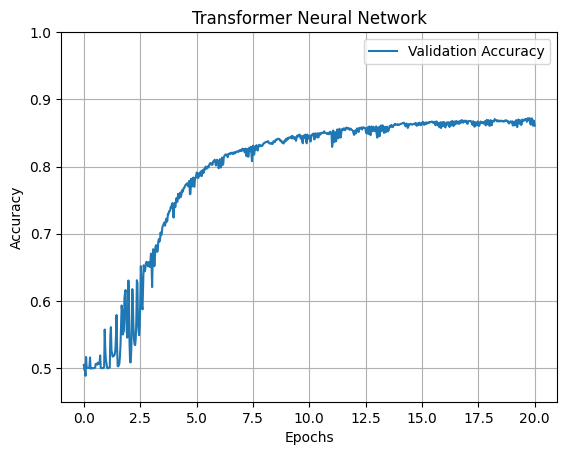

In [44]:
accs = np.load("trained_models/acc.npy")
plt.style.use('default')
plt.plot(np.linspace(0, 20, len(accs)), accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.45, 1)
plt.grid()
plt.title("Transformer Neural Network")
plt.legend()
plt.show()


# Testing

In [37]:
test_review = next(iter(test_data_loader))["id"][0]
text = []
for num in list(test_review.numpy())[preview]:
    text.append(str(vocab.get_itos()[num]))
    print(vocab.get_itos()[num])

i
went
and
saw
this
movie
last
night
after
being


In [38]:
test_review.unsqueeze(0).shape

torch.Size([1, 512])

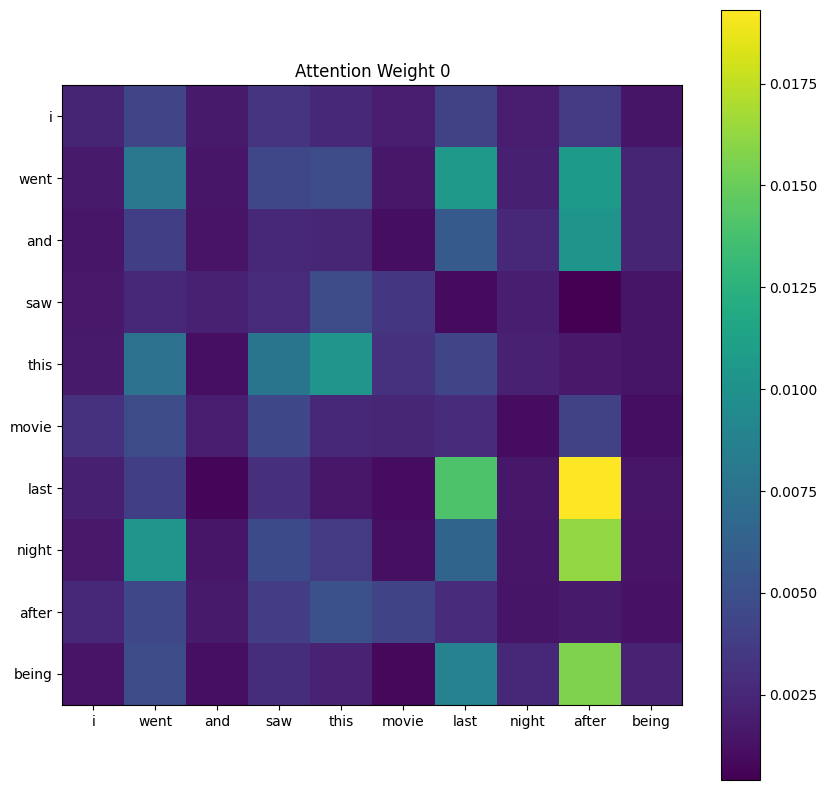

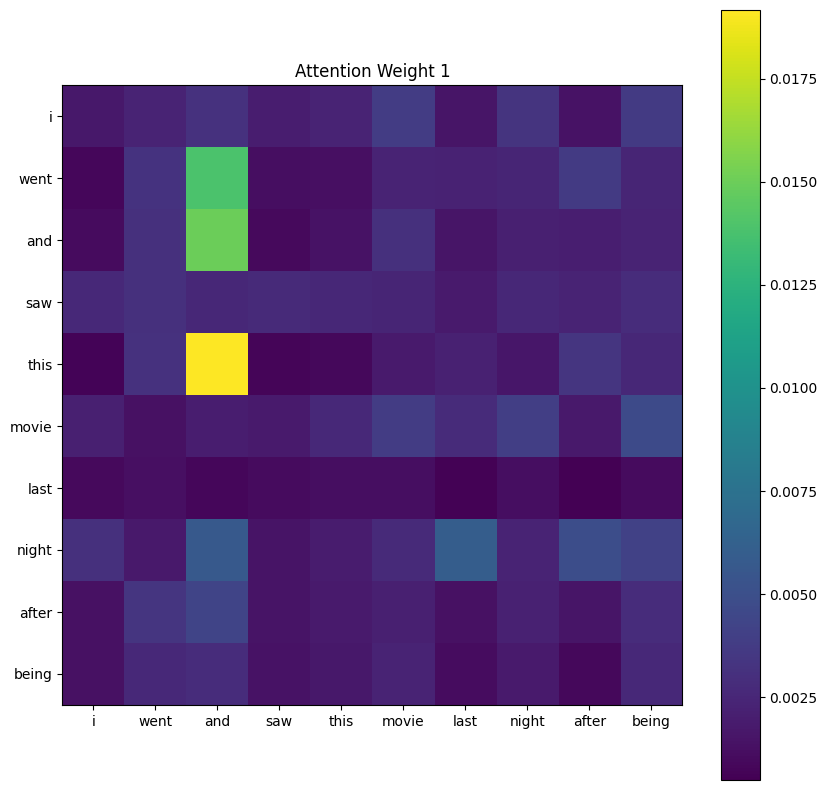

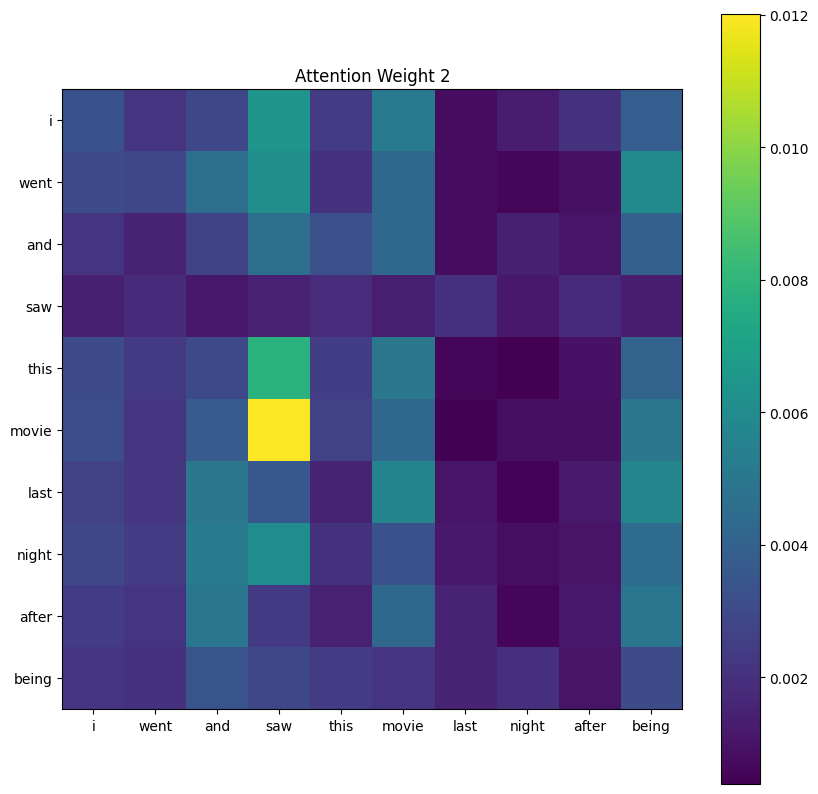

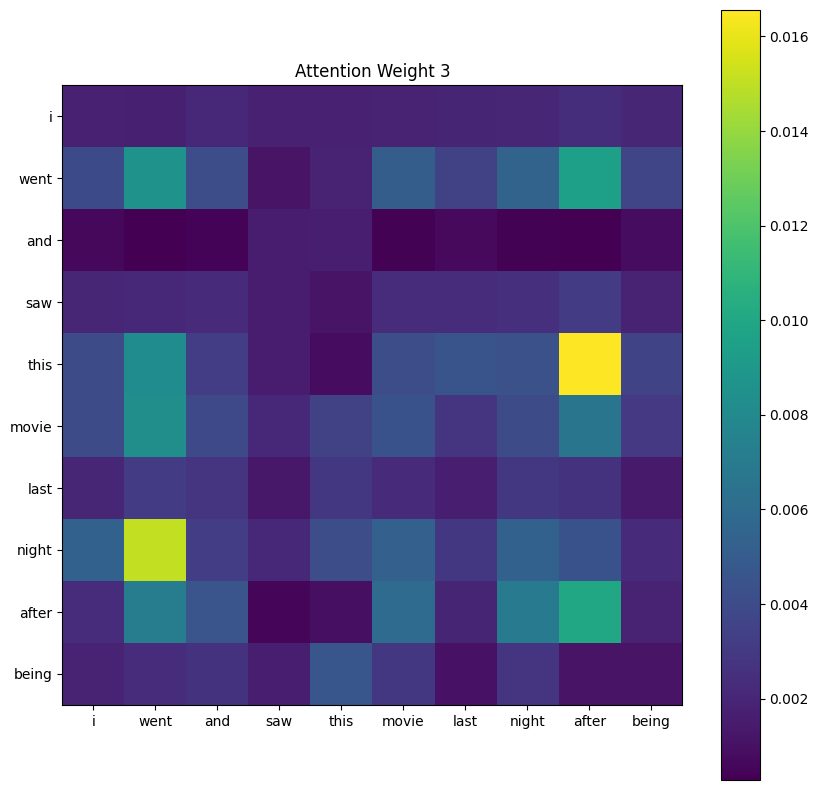

In [39]:
with torch.no_grad():
    _, attention = model(test_review.unsqueeze(0).to("cuda"))
    attention_weights = attention.cpu().numpy()   
for (i, attention) in enumerate(attention_weights):
    plt.style.use('default')
    plt.figure(figsize=(10,10))
    plt.imshow(attention[:10, :10]) 
    plt.xticks(np.arange(0, 10), text[:10])
    plt.yticks(np.arange(0, 10), text[:10])
    plt.colorbar()
    plt.title("Attention Weight {}".format(i))
    plt.show()